In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import yfinance as yf
import pandas as pd

# 1. Define your professional "Resume Set"
tickers = ['AAPL', 'NVDA', 'JPM', 'XOM', 'KO', '^GSPC'] # Tech, Finance, Energy, Consumer, S&P 500

# 2. Create a local directory for data
os.makedirs('data', exist_ok=True)

# 3. Batch Download and Save
def build_database(ticker_list):
    for ticker in ticker_list:
        print(f"Downloading {ticker}...")
        df = yf.download(ticker, period='5y', interval='1d')
        
        # Save each to a separate CSV
        file_path = f"data/{ticker}_historical.csv"
        df.to_csv(file_path)
        print(f"Saved to {file_path}")

build_database(tickers)

# 4. Verify the files exist
print("\nFiles in your Database:")
print(os.listdir('data'))

/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/AAPL_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/NVDA_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/JPM_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/XOM_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/KO_historical.csv


[*********************100%***********************]  1 of 1 completed

Saved to data/^GSPC_historical.csv

Files in your Database:
['AAPL_historical.csv', 'NVDA_historical.csv', 'XOM_historical.csv', 'JPM_historical.csv', '^GSPC_historical.csv', 'KO_historical.csv']


In [3]:
%%writefile preprocess.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class MarketPreprocessor:
    def __init__(self, window_size=60):
        self.window_size = window_size
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def get_technical_indicators(self, df):
        df = df.copy()

        # Ensure numeric Close
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
        df.dropna(subset=['Close'], inplace=True)

        # Moving Average
        df['MA20'] = df['Close'].rolling(window=20, min_periods=20).mean()

        # RSI
        delta = df['Close'].diff()
        gain = delta.clip(lower=0).rolling(window=14).mean()
        loss = -delta.clip(upper=0).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        return df.dropna()

    def create_sequences(self, data):
        scaled_data = self.scaler.fit_transform(data)
        X, y = [], []

        for i in range(self.window_size, len(scaled_data)):
            X.append(scaled_data[i-self.window_size:i])
            y.append(scaled_data[i, 0])

        return np.array(X), np.array(y)


Writing preprocess.py


In [4]:
import matplotlib.pyplot as plt

def plot_indicators(df, ticker):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Price + MA
    ax1.plot(df.index, df['Close'], label='Close')
    ax1.plot(df.index, df['MA20'], label='MA20')
    ax1.set_title(f'{ticker} Price & Moving Average')
    ax1.legend()
    ax1.grid(True)

    # RSI
    ax2.plot(df.index, df['RSI'], label='RSI')
    ax2.axhline(70, linestyle='--')
    ax2.axhline(30, linestyle='--')
    ax2.set_ylim(0, 100)
    ax2.set_title('RSI')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


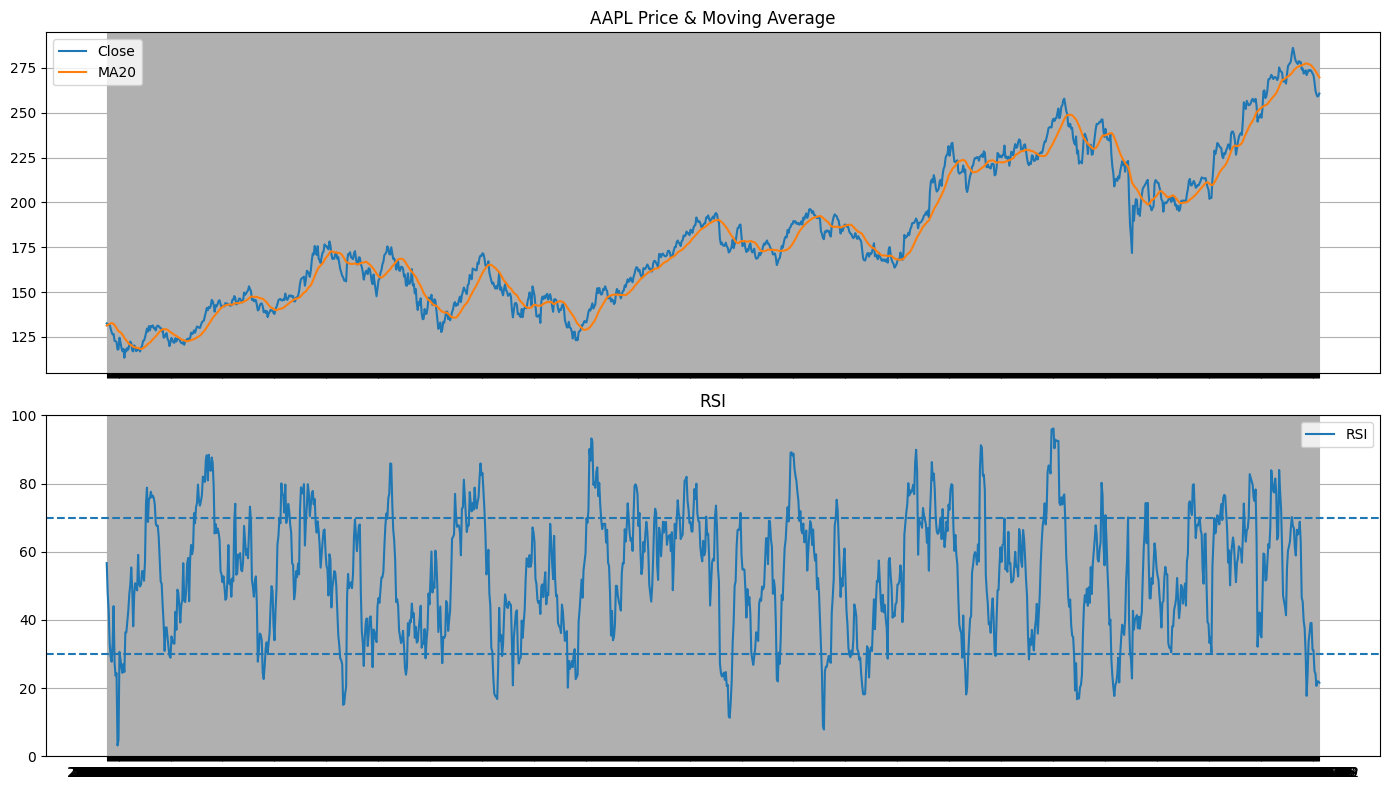

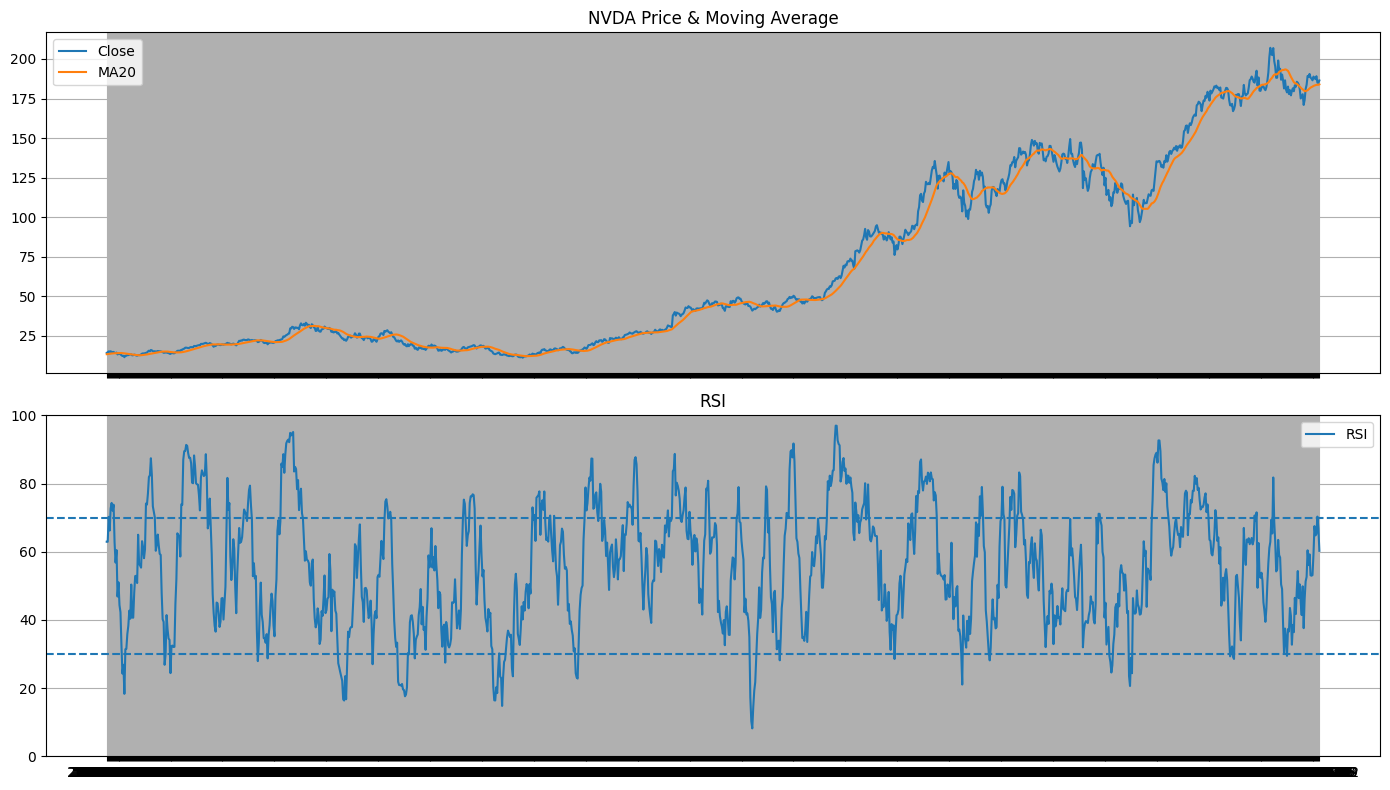

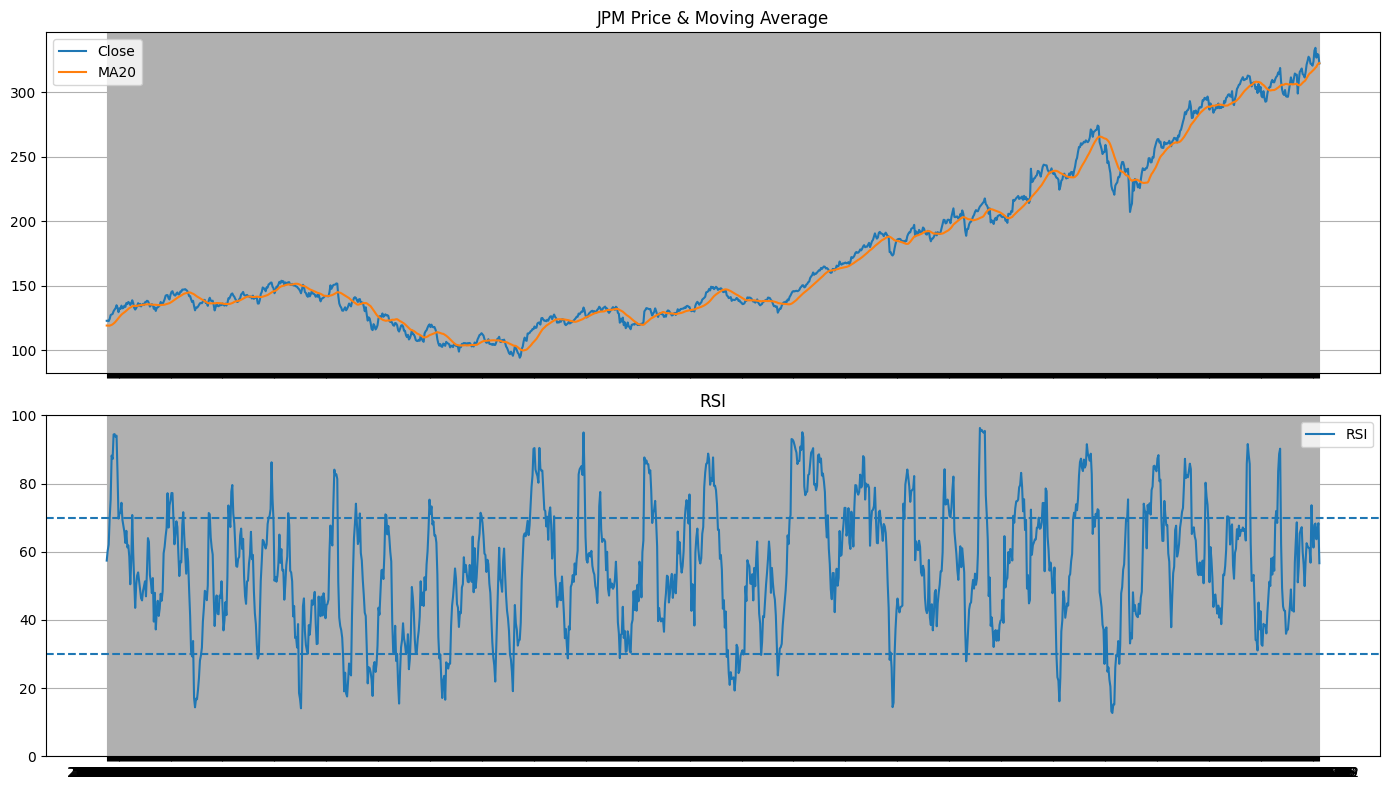

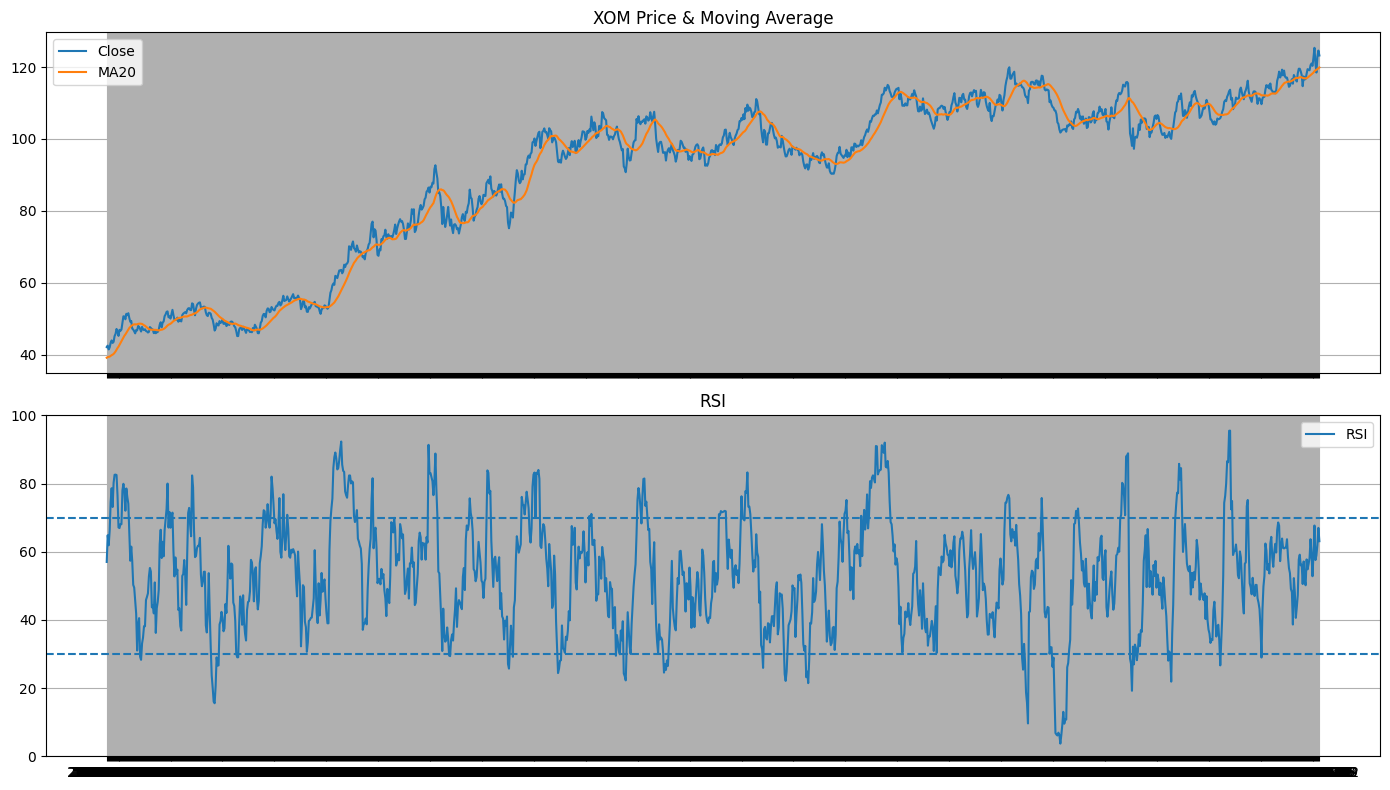

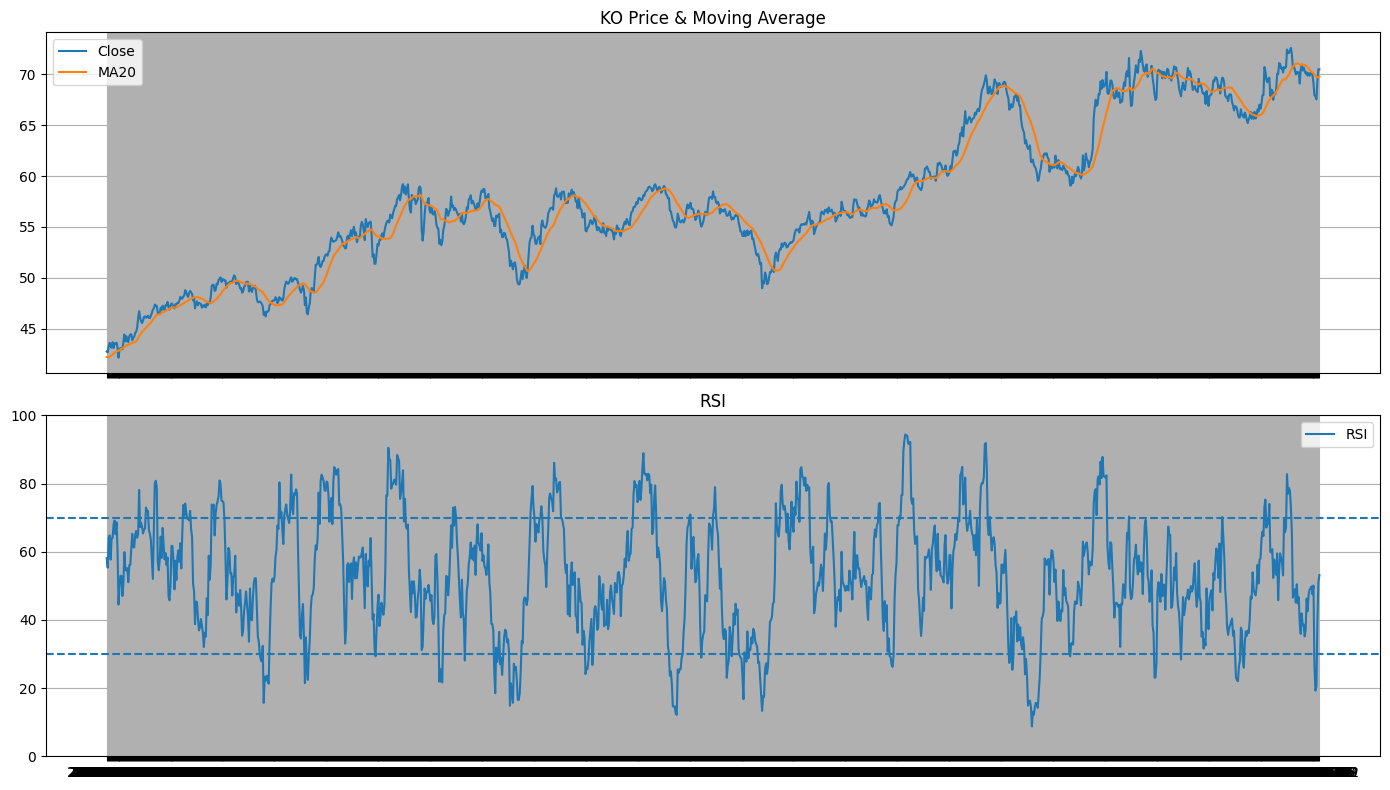

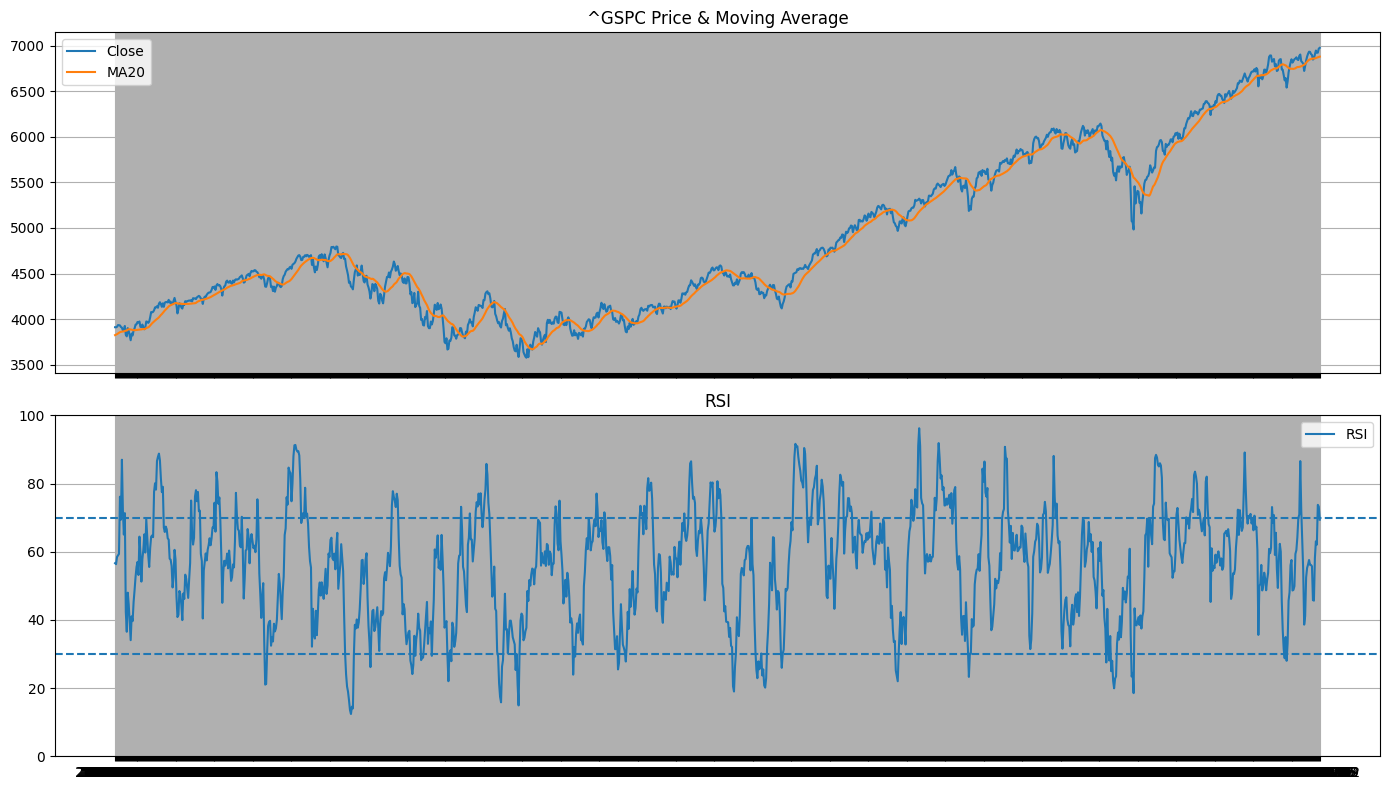

In [5]:
from preprocess import MarketPreprocessor
handler = MarketPreprocessor(window_size=60)
for ticker in tickers:
    df = pd.read_csv(f'data/{ticker}_historical.csv', index_col=0)

    # ---- Handle MultiIndex properly ----
    if isinstance(df.columns, pd.MultiIndex):
        if 'Close' not in df.columns.get_level_values(0):
            print(f"'Close' not found for {ticker}")
            continue

        # ⬇️ Extract SERIES, not DataFrame
        close_series = df.xs('Close', axis=1, level=0).iloc[:, 0]

    else:
        if 'Close' not in df.columns:
            print(f"'Close' not found for {ticker}")
            continue

        close_series = df['Close']

    # ---- Force numeric BEFORE preprocessing ----
    close_series = pd.to_numeric(close_series, errors='coerce')

    # ---- Rebuild clean DataFrame ----
    close_df = pd.DataFrame({'Close': close_series})

    # ---- Now this is 100% safe ----
    df_processed = handler.get_technical_indicators(close_df)

    plot_indicators(df_processed, ticker)


In [6]:
import os
import pandas as pd
from preprocess import MarketPreprocessor

# 1. Initialize
preprocessor = MarketPreprocessor(window_size=60)
data_dir = 'data'
all_X = []
all_y = []

# 2. List all CSV files in your data folder
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

for file in csv_files:
    # Load each company
    file_path = os.path.join(data_dir, file)
    # The 'date_format' argument explicitly tells pandas the layout of your date strings
    df = pd.read_csv(file_path, index_col=0, parse_dates=True, date_format='%Y-%m-%d')
    
    # Step A: Preprocess (Technical Indicators)
    df_featured = preprocessor.get_technical_indicators(df)
    
    # Step B: Select your features
    feature_columns = ['Close', 'MA20', 'RSI']
    feature_data = df_featured[feature_columns].values
    
    # Step C: Create sequences for THIS specific file
    X_company, y_company = preprocessor.create_sequences(feature_data)
    
    all_X.append(X_company)
    all_y.append(y_company)

# 3. Combine into final master datasets
import numpy as np
X = np.concatenate(all_X, axis=0)
y = np.concatenate(all_y, axis=0)

print(f"Dataset compiled from {len(csv_files)} files.")
print(f"Final X shape: {X.shape}")

Dataset compiled from 6 files.
Final X shape: (7062, 60, 3)


In [7]:
# Flatten for Scikit-Learn models
X_flat = X.reshape(X.shape[0], -1) 
# Now shape is (4700, 180) because 60 * 3 = 180

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 2. Define the models to compare
models = {
    "Linear_Regression": LinearRegression(),
    "Random_Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
}

# 3. Storage for results
performance_metrics = {name: [] for name in models.keys()}

print("Starting Walk-Forward Validation...")

# 4. Cross-Validation Loop
for train_index, test_index in tscv.split(X_flat):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        # We use MAE (Mean Absolute Error) as it's easy to explain in your README
        error = mean_absolute_error(y_test, preds)
        performance_metrics[name].append(error)

# 5. Final Comparison
for name, errors in performance_metrics.items():
    print(f"{name} Average MAE: {np.mean(errors):.4f}")

Starting Walk-Forward Validation...
Linear_Regression Average MAE: 0.0206
Random_Forest Average MAE: 0.0142


In [9]:
def plot_cv_scores(performance_metrics):
    labels = [f"Fold {i+1}" for i in range(len(next(iter(performance_metrics.values()))))]
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, performance_metrics['Linear_Regression'], width, label='Linear')
    ax.bar(x + width/2, performance_metrics['Random_Forest'], width, label='Random Forest')
    
    ax.set_ylabel('MAE (Lower is Better)')
    ax.set_title('Model Error per TimeSeriesSplit Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

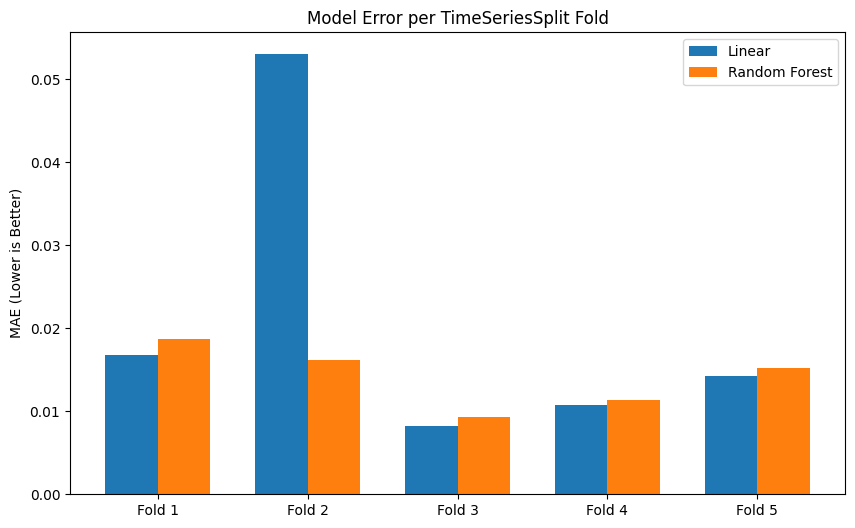

In [10]:
plot_cv_scores(performance_metrics)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

def build_lstm_model(input_shape):
    model = Sequential([
        # We define the input shape (60 days, 3 features)
        Input(shape=input_shape),
        
        # First LSTM layer: return_sequences=True because we want the next LSTM layer 
        # to see the sequence as well.
        LSTM(units=50, return_sequences=True),
        Dropout(0.2), # Prevents overfitting (Regularization)
        
        # Second LSTM layer: return_sequences=False because the next layer is Dense.
        # This "collapses" the sequence into a single memory vector.
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        
        # Dense layers translate the memory into a price prediction.
        Dense(units=25),
        Dense(units=1) 
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the model
# input_shape is (60, 3) -> 60 time steps, 3 features
model_lstm = build_lstm_model((60, 3))


2026-01-12 18:22:41.416845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768242161.766709      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768242161.874041      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768242162.763747      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768242162.763810      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768242162.763813      17 computation_placer.cc:177] computation placer alr

In [12]:
import tensorflow as tf

# Define the early_stop variable
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Watch the validation loss
    patience=5,             # Number of epochs to wait for improvement before stopping
    restore_best_weights=True # After stopping, keep the version of the model that performed best
)

In [13]:
# 1. Reshape the flattened data back to (Samples, 60, 3)
X_train_lstm = X_train.reshape(X_train.shape[0], 60, 3)
X_test_lstm = X_test.reshape(X_test.shape[0], 60, 3)

# 2. Now run the training with the correctly shaped data
history = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0186 - val_loss: 0.0016
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0013 - val_loss: 9.5335e-04
Epoch 10/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0012 - val_loss: 8.2221e-04
Epoch 11/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0012 - val_loss: 7.9737e-04
Epoch 12/50
184/18

In [14]:
# 1. Predict
X_test_lstm = X_test.reshape(X_test.shape[0], 60, 3)

lstm_preds = model_lstm.predict(X_test_lstm)

# 2. Evaluate (using the same metrics as your other models)
from sklearn.metrics import mean_absolute_error
lstm_mae = mean_absolute_error(y_test, lstm_preds)

print(f"LSTM Average MAE: {lstm_mae:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
LSTM Average MAE: 0.0186
